# Probabilistic programming in Python using PyMC3

A journey though Salvatier+Wiecki+Fonnesbeck: [*Probabilistic programming in Python using PyMC3*](https://peerj.com/articles/cs-55/) (2016), which is also given as PyMC3 tutorial on the website. Also peeking at [getting started guide](http://pymc-devs.github.io/pymc3/notebooks/getting_started.html) which is an edited copy of the Peer J publication.

The Peer J has open review, which is really useful for me in general. One commentor argues PyMC is not a probabilistic programming language as it is not Turing-complete, like e.g. Church. But many of the other PPLs are integrated into a host langauge too, e.g. WebPPL (I don't know if they are TC).

PyMC3 uses [No-U-Turn Sampler](https://arxiv.org/pdf/1111.4246v1.pdf) (NUTS), which is a self-tuning variant of Hamiltonian Monte Carlo (HMC). HMC's avoid issues with less efficient sampling algorithms such as random walk Metropolis or Gibbs sampling, but HMCs are sensitive to two gradient parameters: numbers of steps $L$ and step length $\epsilon$. NUTS self-tunes $L$.

PyMC3 uses Theano for expressions to be defined using generalized vector data structures called *tensors*, integrated with *NumPy* `ndarray` data structures. Theano can also use the GPU. *Patsy* for defining formulas I think.

A motivating example: linear regression. A simple Bayesian linear regression model with normal priors on the parameters. Prediction of $Y$ as normally distributed observations with an expected value $\mu$ that is a linear function of two predictor values $X_1$ and $X_2$.

$Y \sim \mathcal{N} (\mu, \sigma^2)$, where $\mu = \alpha + \beta_1 X_1 + \beta_2 X_2$

With the following means and variances $\alpha \sim \mathcal{N}(0, 10)$, $\beta_i \sim \mathcal{N}(0, 10)$ and $\sigma \sim | \mathcal{N}(0, 1) |$.

In [71]:
import numpy as np
import scipy
import pandas as pd
import pandas_datareader
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
np.random.seed(123)

# true parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# size of dataset
size = 100

# predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# simulate outcome variable
Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma

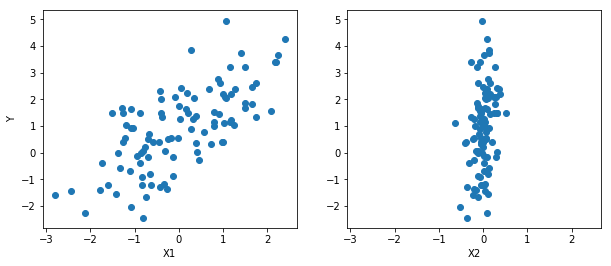

In [21]:
fix, axes = plt.subplots(1, 2, sharex=True, figsize=(10, 4))
axes[0].scatter(X1, Y)
axes[1].scatter(X2, Y)
axes[0].set_ylabel('Y')
axes[0].set_xlabel('X1')
axes[1].set_xlabel('X2')

Specifying the above in PyMC3.

In [23]:
import pymc3

In [40]:
basic_model = pymc3.Model()
with basic_model: # using contexts in PyMC3
    # priors for unknown model parameters
    alpha = pymc3.Normal('alpha', mu=0, sd=10)
    beta = pymc3.Normal('beta', mu=0, sd=10, shape=2)
    sigma = pymc3.HalfNormal('sigma', sd=1)
    
    # expected value of outcome
    mu = alpha + beta[0]*X1 + beta[1]*X2
    
    # likelihood (sampling distribution) of observation
    Y_obs = pymc3.Normal('Y_obs', mu=mu, sd=sigma, observed=Y)

Model fitting. Ideally this should be done analytically, but as this is often not feasible for non-trivial models, we consider two approaches: finding the *maximum a posteriori* (MAP) point using optimization, and computing summaries based on samples drawn from the posterior distribution using Markov Chain Monte Carhlo (MCMC) sampling methods.

## MAP

MAP find the mode of the posterior distribution and is often easy but only gives a point estimates for the parameters and might be biased if the mode is not representative of the distribution.

In [44]:
map_estimate = pymc3.find_MAP(model=basic_model)
print(map_estimate)

Optimization terminated successfully.
         Current function value: 149.017982
         Iterations: 16
         Function evaluations: 21
         Gradient evaluations: 21
{'alpha': array(0.9065985497559482), 'beta': array([ 0.94848602,  2.60705514]), 'sigma_log_': array(-0.032781470174030665)}


## Sampling

Also gives uncertainty measures, unlike point estimate MAP. We provide a step method that corresponds to a particular MCMC algorithm.

NUTS requires a scaling matrix parameter to facilitate sampling, but PyMC3 uses auto-diff variational inference (ADVI) to initialize NUTS.

In [49]:
with basic_model:
    # draw 2000 posterior samples
    trace = pymc3.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -153.48: 100%|██████████| 200000/200000 [00:20<00:00, 9762.40it/s] 
Finished [100%]: Average ELBO = -153.51
100%|██████████| 2000/2000 [00:03<00:00, 544.79it/s]


`pymc3.sample` runs the step method(s) assigned to it, and returns a `pymc3.Trace` object containing the sample collected.

The `trace` object can be queried in a similar way to a `dict` containing a map from variable names to `numpy.array`s; the first dimension of the array is the sampling index and the later dimensions match the shape of the variable.

In [67]:
trace.varnames

['alpha', 'beta', 'sigma_log_', 'sigma']

In [66]:
trace['alpha'][-5:]

array([ 1.06951402,  1.06951402,  0.84731803,  0.97774424,  0.91704592])

We could be using other step function too, e.g. `pymc3.Slice` instead of NUTS.

In [60]:
with basic_model:
    # obtain starting values with MAP
    start = pymc3.find_MAP(fmin=scipy.optimize.fmin_powell)
    
    # instantiate sampler
    step = pymc3.Slice(vars=[sigma])
    
    # draw 5000 posterior samples
    trace = pymc3.sample(5000, step=step, start=start)

Assigned NUTS to alpha
Assigned NUTS to beta


Optimization terminated successfully.
         Current function value: 149.019762
         Iterations: 4
         Function evaluations: 176


100%|██████████| 5000/5000 [00:08<00:00, 586.51it/s]


Posterior analysis.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10f785940>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10f029978>]], dtype=object)

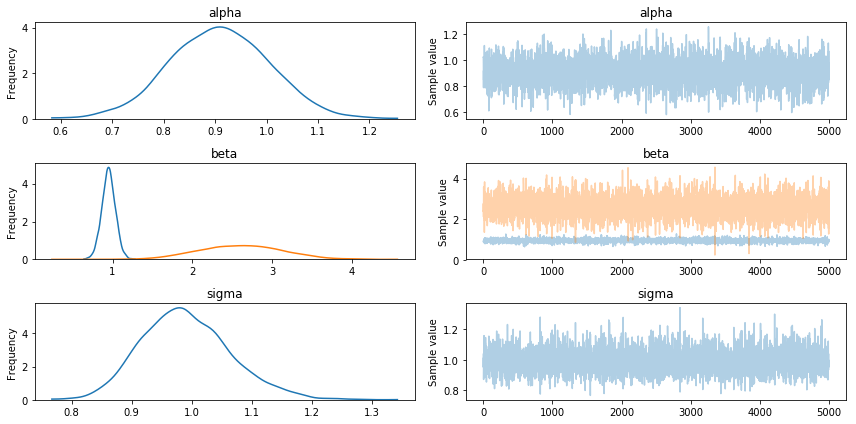

In [69]:
pymc3.traceplot(trace)

Left column is a smoothed histogram of the marginal posteriors of each stochastic random variable. The right column contains the samples of the Markov chain plotted in sequential order. The `beta` variable produces two histograms and traces, corresponding to both predictor coefficients.

In [70]:
pymc3.summary(trace)


alpha:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.908            0.097            0.002            [0.715, 1.097]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.717          0.842          0.908          0.974          1.100


beta:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.951            0.086            0.001            [0.788, 1.123]
  2.606            0.521            0.007            [1.636, 3.620]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.781          0.895          0.951          1.007          1.119
  1.629          2.248          2.607   

## Case study 1: Stochastic volatility

A stock market volatility study. Distribution of market returns is highly non-normal. This example has >400 parameters.

Asset prices have time-varying volatility. Here we use a latent volatility variable, which changes over time.

Exponential distributions for $\sigma$ and $v$ priors, Student-T for returns, and gaussian random walk for the prior for the latent volatiles. $\sigma \sim exp(50)$. 
$v \sim exp(.1)$,$s_i \sim \mathcal{N}(s_{i - 1}, \sigma^2)$, $log(y_i) \sim t(v, 0, exp(-2s_i))$. $y$ is the daily return series which is modeled with a Student-t distribution with an unknown degree of freedom parameter, and a scale parameter determined by a latent process $s$. The individual $s_i$ are the individual log volatitlities in the latend log volatility process.

In [73]:
returns = pandas_datareader.data.get_data_yahoo('SPY', start='2008-5-1', end='2009-12-1')['Adj Close'].pct_change()
print(len(returns))

401


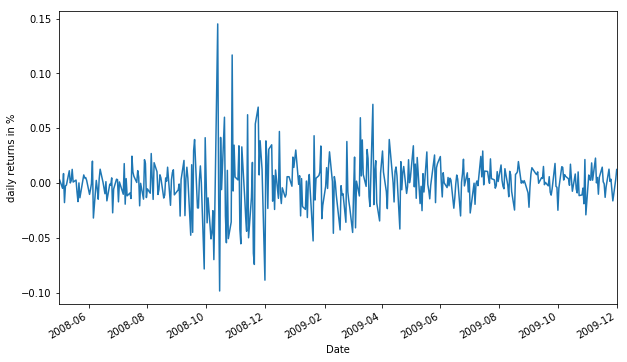

In [75]:
returns.plot(figsize=(10, 6))
plt.ylabel('daily returns in %')

We can specify starting values for variable at the model specification stage. Usually not necessary, but we can override the default staring value (mean, median or mode of the distribution, usually) avoid invalid values etc.

In [82]:
with pymc3.Model() as sp500_model:
    nu = pymc3.Exponential('nu', 1./10, testval=5.)
    sigma = pymc3.Exponential('sigma', 1./.02, testval=.1)
    s = pymc3.GaussianRandomWalk('s', sigma**-2, shape=len(returns))
    volatility_process = pymc3.Deterministic('volatility_process', scipy.exp(-2*s))
    r = pymc3.StudentT('r', nu, lam=1/volatility_process, observed=returns)

The Peer J publication sets the start and step values before sampling.

Notice the log transforms above.

In [83]:
with sp500_model:
    trace = pymc3.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = 883.26: 100%|██████████| 200000/200000 [00:47<00:00, 4218.76it/s]
Finished [100%]: Average ELBO = 883.12
100%|██████████| 2000/2000 [04:00<00:00,  8.30it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x113ed3940>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1136ae198>]], dtype=object)

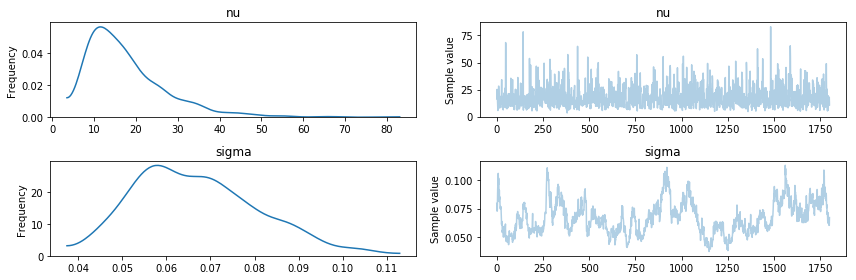

In [84]:
pymc3c3.traceplot(trace[200:], [nu, sigma])

Plot the distribution of volatility paths by plotting many of our sampled paths on the same graph.

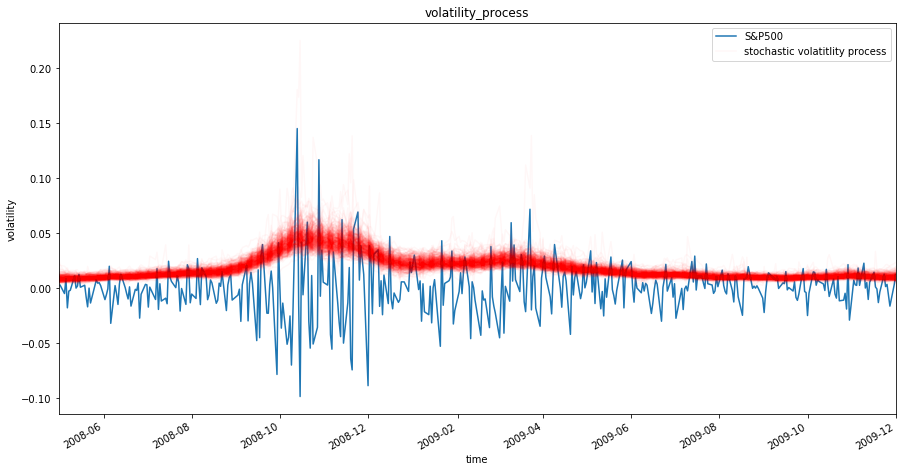

In [89]:
fix, ax = plt.subplots(figsize=(15, 8))
returns.plot(ax=ax)
ax.plot(returns.index, 1/np.exp(trace['s', ::5].T), 'r', alpha=.03)
ax.set(title='volatility_process', xlabel='time', ylabel='volatility')
ax.legend(['S&P500', 'stochastic volatitlity process'])

Model correctly infers the increase of volatility during the 2008 financial crash.

## Case study 2: coal mining disasters

UK 1851 to 1962. Improved safety when new regulation was provided, this case attempts to predict that time. Note the missing data indicated by '-999'.

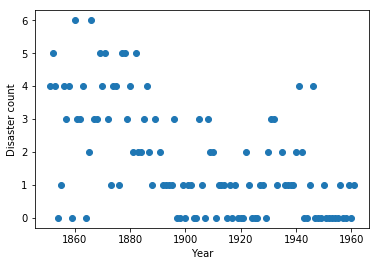

In [90]:
disaster_data = np.ma.masked_values([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                                     3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                                     2, 2, 3, 4, 2, 1, 3, -999, 2, 1, 1, 1, 1, 3, 0, 0,
                                     1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                                     0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                                     3, 3, 1, -999, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                                     0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1], value=-999)
year = np.arange(1851, 1962)

plt.plot(year, disaster_data, 'o')
plt.xlabel('Year')
plt.ylabel('Disaster count')

Occurrences of disasters is thought to follow a Poisson process with a large rate parameter in the early part of the time series, and from one with a smaller rate in the later part. We are interested in locating the change point in the series, which perhaps is related to changes in mining safety regulations.

$D_i \sim Pois(r_i), r_t$,
$r = l if t < s$, e if t ≥ s$,
$s \sim Unif(t_l, t_h)$,
$e \sim exp(1)$,
$l \sim exp(1)$

$D_t$ is the number of years in year $t$, $r_t$ the rate parameter of Poisson distribution of disasters in year $t$, $s$ the year in which the rate parameter changes, $e$ the rate parameter before the switchpoint $s$, $l$ the rate parameter after the switchpoint $s$, $t_l, t_h$ the lower and upper boundaries of year $t$.

In [103]:
with pymc3.Model() as disaster_model:
    switchpoint = pymc3.DiscreteUniform('switchpoint', lower=year.min(), upper=year.max(), testval=1900)
    
    # priors for pre- and post-switch rates number of disasters
    early_rate = pymc3.Exponential('early_rate', 1)
    late_rate = pymc3.Exponential('late_rate', 1)
    
    # allocate appropriate Poisson rates to years before and after current
    rate = pymc3.math.switch(switchpoint >= year, early_rate, late_rate)
    
    disasters = pymc3.Poisson('disasters', rate, observed=disaster_data)

We have discrete variable and so cannot use NUTS. Instead we will use `Metropolis` step method. We also mask missing values which creates a new variable in the model called `disasters_missing`. The tutorial version of this publication allows PyMC3 to select the sampling itself, the Peer J defines them explicitly. I wrote the latter below.

In [105]:
with disaster_model:
    step1 = pymc3.NUTS([early_rate, late_rate])
    step2 = pymc3.Metropolis([switchpoint, disasters.missing_values[0]])
    trace = pymc3.sample(10000, step=[step1, step2])

100%|██████████| 10000/10000 [00:13<00:00, 730.62it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x117c7c470>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x117f2d2b0>]], dtype=object)

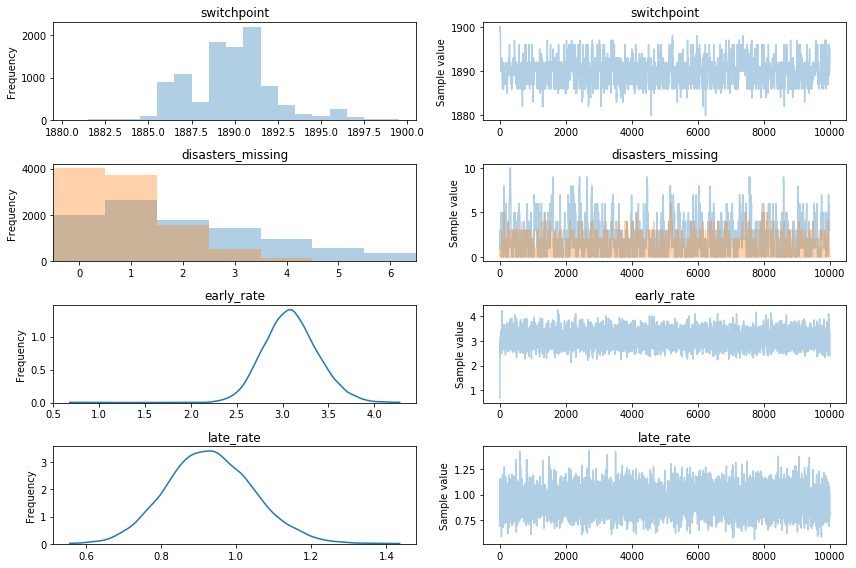

In [106]:
pymc3.traceplot(trace)

## Extending

Both arbitrary deterministics and distributions can be defined, via Theano.

## Generalized linear models

Using the `glm` submodule, with nice R-like syntax via the *Patsy* module. Error distribution is assumed to be normal, unless specifies with `family` parameter to `glm`.

In [107]:
df = pd.DataFrame({'x1': X1, 'x2': X2, 'y': Y})

In [108]:
with pymc3.Model() as model_glm:
    pymc3.glm.glm('y ~ x1 + x2', df)
    trace = pymc3.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -190.04: 100%|██████████| 200000/200000 [00:22<00:00, 8896.28it/s] 
Finished [100%]: Average ELBO = -190.04
100%|██████████| 5000/5000 [00:08<00:00, 601.20it/s]


## Backends

Including in-memory, flat file, SQLite.